In [1]:
import pandas as pd
import numpy as np
import random
from random import sample
from sklearn.linear_model import enet_path
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm

seed = 2023
random.seed(seed)

df = pd.read_excel("Data/S1%20File.xlsx")

#cleaning
df.drop(columns=["Average weekday", "Average weekend day"], inplace=True)
df.dropna(inplace=True)

#Lista ordine delle colonne
columns_order = df.columns

#Cambio del valore in Genere 1:Maschio 0:Femmina
df["Gender"] = np.where(df["Gender"] == 2, 1,0)

#Inserita la nuova colonna prima della normalizzazione
df["HADS_Score"] = df["Total anxiety score"] + df["Total Depression score"]
#Normalizzazione
gender = df["Gender"]
id_no = df["ID No"]
df.drop(columns=["Gender", "ID No"], inplace=True)

df = (df - df.mean())/df.std()
df["Gender"] = gender
#df["ID No"] = id_no

#df = df[columns_order]
df.reset_index(drop=True, inplace=True)



In [2]:
#Nuova colonna ansia + depressione = HADS_Score
df.drop(columns=["Total anxiety score", "Total Depression score"], inplace=True)

In [3]:
def sample_DataFrame(df:pd.DataFrame,sample_percentage_size:float,seed:int)->pd.DataFrame:
    """"Funzione per campionare una percentuale dei dati dal DataSet."""
    if not (0.0 < sample_percentage_size < 1):
        raise AttributeError(f"sample_percentage_size must be in (0,1), got {sample_percentage_size} instead.")
    random.seed(seed)
    sample_size = round(df.shape[0] * sample_percentage_size)
    sample_idx = sample(range(0,df.shape[0]),sample_size)
    return df.iloc[sample_idx]

def split_DataFrame(df:pd.DataFrame, sample_percentage_size=0.5)->tuple[pd.DataFrame,pd.DataFrame]:
    """Funzione per dividere il Dataset in 2 parti. Il primo Dataset ha elementi pari alla percentuale fornita."""
    df1 = sample_DataFrame(df,sample_percentage_size,seed)
    df2 = df.drop(df1.index)
    print(f"First DataFrame has {df1.shape[0]} items, Second DataFrame has {df2.shape[0]} items.")
    return df1,df2
    

In [4]:
test, remaining = split_DataFrame(df,0.3)

training, validation = split_DataFrame(remaining,0.5)


First DataFrame has 20 items, Second DataFrame has 45 items.
First DataFrame has 22 items, Second DataFrame has 23 items.


# Regressione lineare

Ipotizziamo che ci sia una relazione lineare tra il punteggio **HADS** e le altre variabili. Tale punteggio è ottenuto dalla somma del punteggio dell'ansia totale e la depressione totale.
Indica la severità della depressione (0,21). L'obbiettivo è prevedere tale punteggio.




## Calcolo dei coefficienti, p-value e intervalli di confidenza in maniera "onesta".

La procedura per il calcolo dei coefficienti, p-value e intervalli di confidenza in maniera "onesta" è la seguente:

1. Dividere il Dataset in 2 parti: Training e Validation
2. Applicare un qualsiasi stimatore regolarizzato ai dati di Validation
3. Adattare ai parametri diversi da zero del passo precedente una regressione lineare classica ai dati di Training.

> I coefficienti che al passo 2 sono 0, hanno p-value = 1.

### Stimatore Regolarizzato: Elastic Net

Utiliziamo lo stimatore Elastic Net con rapporto 1:1 tra RIDGE e LASSO.
Inizialmente guardiamo il Path dello stimatore per $\alpha \in [0.05,2]$.


Text(0.5, 1.0, 'Elastic-Net Paths')

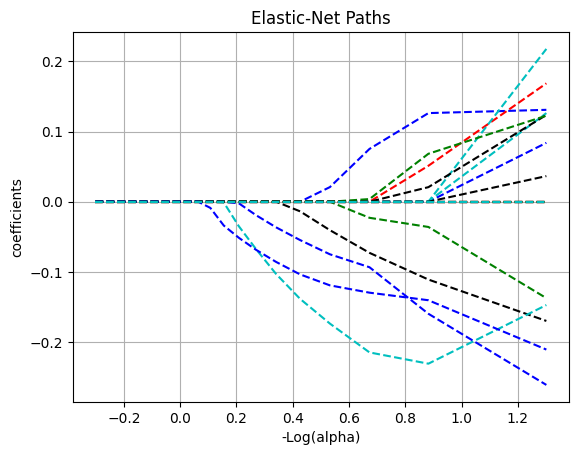

In [5]:
X_validation = validation.drop("HADS_Score",axis=1)
y_validation = validation["HADS_Score"]


alphas_array = np.linspace(0.05,2,25)
alphas, coefs, _ = enet_path(X_validation, y_validation, alphas= alphas_array, l1_ratio=0.5)

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])

neg_log_alphas = -np.log10(alphas)
for coef, c in zip(coefs, colors):
    l2 = plt.plot(neg_log_alphas, coef, linestyle="--", c=c)
plt.grid()

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net Paths")


#### Scelta dell' Iperparametro $\alpha$

Utilizziamo la configurazione descritta sopra per tunare $\alpha$ tramite cross-validation.

In [6]:
elastic_net = ElasticNetCV(cv=5, fit_intercept=False,alphas=alphas_array,random_state=seed,l1_ratio = 0.5)
elastic_net.fit(X_validation, y_validation)
print(f"Best alpha is: {elastic_net.alpha_}")

Best alpha is: 0.13125


#### Visualizzazione dei coefficienti diersi da 0

In [7]:
coefficients = list(zip(X_validation.columns,elastic_net.coef_))
coefficients_copy = coefficients.copy()
for coefficient in coefficients_copy:
    if np.isclose(coefficient[1],0.0):
        coefficients.remove(coefficient)
print(f"Non zero coefficients are:\n {coefficients}")


Non zero coefficients are:
 [('Age', 0.1264087567605224), ('Height (m)', 0.05127895746775435), ('Weight (kgs)', -0.03599197494831645), ('working hours per week', -0.11098045472641244), ('MH', -0.23096965212543707), ('Sitting only', 0.0004782183646453198), ('Time standing (h)', 0.020783819430077382), ('Time stepping (h)', -0.15977600082888663), ('Sit to stand transitions', 0.06841134245284378), ('Time stepping (h).1', -0.14049614180189837)]


### Regressione lineare classica

Adesso che abbiamo il nome dei coefficienti diversi da 0, possiamo usarli per la regressione lineare classica

In [8]:
coefficients_name = [coefficient[0] for coefficient in coefficients]

X_training = training.drop("HADS_Score",axis=1)
y_training = training["HADS_Score"]

X_training = X_training.loc[:,X_training.columns.isin(coefficients_name)]


In [9]:
X_training = sm.add_constant(X_training)
least_square = sm.OLS(y_training, X_training)
results = least_square.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             HADS_Score   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     2.311
Date:                Tue, 28 Nov 2023   Prob (F-statistic):             0.0927
Time:                        12:06:31   Log-Likelihood:                -22.601
No. Observations:                  22   AIC:                             67.20
Df Residuals:                      11   BIC:                             79.20
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Testing

Una volta che il modello è stato stimato, non ci resta altro che testarlo su i dati di test, confrontando MSE dei residui in training con MSE del Test.

In [10]:
y_test = test["HADS_Score"]
X_test = test.loc[:,test.columns != "HADS_Score"]
X_test = X_test.loc[:,X_test.columns.isin(coefficients_name)]
X_test = sm.add_constant(X_test)
predictions = results.predict(X_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("---Training---")
print(f"Residuals MSE Training: {results.mse_resid}")
print("-----Test-----")
print(f"TESt MSE: {mse}")

---Training---
Residuals MSE Training: 0.9138318214309078
-----Test-----
TESt MSE: 0.613953618378116
